In [ ]:
import torch
import matplotlib.pyplot as plt
import re
import warnings
import nltk
import os
import pandas as pd
import seaborn as sns
import shutil
import datasets
import spacy
import plotly.express as px
from spacy import displacy
from IPython.display import HTML
from nltk.corpus import stopwords as nltk_sw
from wordcloud import WordCloud, STOPWORDS
from torch.utils.data import DataLoader
from torch.optim import AdamW
from transformers import AutoTokenizer, AutoModelForSequenceClassification, get_scheduler
from transformers import DataCollatorWithPadding
from datasets import load_dataset
from sklearn.metrics import accuracy_score, f1_score
from tqdm.auto import tqdm
from collections import Counter
from nltk.corpus import stopwords
from sklearn.feature_extraction.text import TfidfVectorizer
from sklearn.manifold import TSNE
from sklearn.metrics import confusion_matrix

from tqdm.auto import tqdm
from sklearn.model_selection import train_test_split
from sklearn.metrics import accuracy_score, f1_score
from imblearn.over_sampling import SMOTE
from datasets import Dataset
from torch.utils.data import DataLoader
from torch.optim import AdamW
from transformers import AutoConfig
from transformers import AutoTokenizer, AutoModelForSequenceClassification, get_linear_schedule_with_warmup

In [ ]:
import kagglehub

path = kagglehub.dataset_download("edqian/twitter-climate-change-sentiment-dataset")

print("Path to dataset files:", path)

Using Colab cache for faster access to the 'twitter-climate-change-sentiment-dataset' dataset.
Path to dataset files: /kaggle/input/twitter-climate-change-sentiment-dataset


In [ ]:
csv_path = os.path.join(path, "twitter_sentiment_data.csv")
df = pd.read_csv(csv_path)

In [ ]:
df

,sentiment,message,tweetid
0,-1,@tiniebeany climate change is an interesting hustle as it was global warming but the planet stopped warming for 15 yes while the suv boom,792927353886371840
1,1,"RT @NatGeoChannel: Watch #BeforeTheFlood right here, as @LeoDiCaprio travels the world to tackle climate change https://t.co/LkDehj3tNn httÃ¢â‚¬Â¦",793124211518832641
2,1,Fabulous! Leonardo #DiCaprio's film on #climate change is brilliant!!! Do watch. https://t.co/7rV6BrmxjW via @youtube,793124402388832256
3,1,RT @Mick_Fanning: Just watched this amazing documentary by leonardodicaprio on climate change. We all think thisÃ¢â‚¬Â¦ https://t.co/kNSTE8K8im,793124635873275904
4,2,"RT @cnalive: Pranita Biswasi, a Lutheran from Odisha, gives testimony on effects of climate change &amp; natural disasters on the poÃ¢â‚¬Â¦",793125156185137153
...,...,...,...
43938,1,"Dear @realDonaldTrump,\nYeah right. Human Mediated Climate Change is a Chinese urban legend. https://t.co/LLLx3iEj4y",791307031919550464
43939,1,What will your respective parties do to prevent climate change globally? #ZPNDebate,791316857403936768
43940,2,RT @MikkiL: UN Poll Shows Climate Change Is the Lowest of All Global Concerns https://t.co/OopCQJvoGA,791357509101621249
43941,0,"RT @taehbeingextra: i still can$q$t believe this gif of taehyung saved the human race, stopped global warming and watered every plant on…",791390042136641537


In [ ]:
import nltk
nltk.download('vader_lexicon')
from nltk.sentiment.vader import SentimentIntensityAnalyzer

analyzer = SentimentIntensityAnalyzer()

def get_vader_sentiment(text):
    scores = analyzer.polarity_scores(text)
    return scores['compound']

df['vader_sentiment_score'] = df['message'].apply(get_vader_sentiment)
display(df.head())

[nltk_data] Downloading package vader_lexicon to /root/nltk_data...
[nltk_data]   Package vader_lexicon is already up-to-date!


,sentiment,message,tweetid,vader_sentiment_score
0,-1,@tiniebeany climate change is an interesting hustle as it was global warming but the planet stopped warming for 15 yes while the suv boom,792927353886371840,0.6428
1,1,"RT @NatGeoChannel: Watch #BeforeTheFlood right here, as @LeoDiCaprio travels the world to tackle climate change https://t.co/LkDehj3tNn httÃ¢â‚¬Â¦",793124211518832641,0.0000
2,1,Fabulous! Leonardo #DiCaprio's film on #climate change is brilliant!!! Do watch. https://t.co/7rV6BrmxjW via @youtube,793124402388832256,0.8544
3,1,RT @Mick_Fanning: Just watched this amazing documentary by leonardodicaprio on climate change. We all think thisÃ¢â‚¬Â¦ https://t.co/kNSTE8K8im,793124635873275904,0.6705
4,2,"RT @cnalive: Pranita Biswasi, a Lutheran from Odisha, gives testimony on effects of climate change &amp; natural disasters on the poÃ¢â‚¬Â¦",793125156185137153,-0.2732


In [ ]:
df_sorted = df.sort_values(by='vader_sentiment_score', ascending=False)
display(df_sorted.head(20))

,sentiment,message,tweetid,vader_sentiment_score
23472,1,I'm one of those people who doesn't believe in global warming but I'm pretty sure Noah's ark was a true story' hahaha,878100212396335104,0.9528
5054,-1,"RT @Martin_Durkin: Wonderful Trump appoints the charming, clever, sane Myron Ebell to take on the global warming charlatans. Hurrah!!! httpÃ¢â‚¬Â¦",798151452111892480,0.9483
3960,-1,"RT @Martin_Durkin: Wonderful Trump appoints the charming, clever, sane Myron Ebell to take on the global warming charlatans. Hurrah!!! httpÃ¢â‚¬Â¦",797156815599529984,0.9483
26219,1,We can pray but better to accept climate change is real and join the Paris Climate Agreement (again). https://t.co/IRxOIozXbd,905218903009320960,0.9432
15345,0,@PrisonPlanet wow wow finally climate change is not the evil now you wake up. Good,840975074169634816,0.9327
25306,0,RT @LayaBuurd: i'm alive. my family healthy. my friends prospering. my boyfriend fine. my dogs love me &amp; global warming hasn't kil…,896537136542998528,0.9325
31768,1,RT @aliiexx: picture this: itâ€™s the year 3000. global warming has run its course and we live underwater. your great great great granddaughtâ€¦,960601796656984064,0.9313
4262,1,RT @nadasurf: .@IvankaTrump i really wish climate change wasn't real but i'm afraid it is. please help. the world would be so grateful. alÃ¢â‚¬Â¦,797431688707964928,0.9300
41229,0,RT @CGWM_PBorisoff: https://t.co/RsUQeNYtdb\nToyota: clean #hydrogen is the best fix for global warming and energy security; easier to store…,711749060437213187,0.9300
3900,1,RT @phaninaidu1: Many more happy returns of d day @LeoDiCaprio Ã¢ï†Â¤Ã°Å¸Ëœï† hope you'll succeed wd ur efforts on climate change @vishnupspk_fan @shaÃ¢â‚¬Â¦,797115243604234240,0.9299


## Check Duplicated Value

In [ ]:
duplicate_rows = df[df.duplicated(subset=['message', 'vader_sentiment_score'], keep=False)]
duplicate_rows_sorted = duplicate_rows.sort_values(by='message')
display(duplicate_rows_sorted.head(10))

,sentiment,message,tweetid,vader_sentiment_score
6926,1,#Rigged #StrongerTogether #DNCLeak #Debate #Iamwithher climate change is directly related to global terrorism https://t.co/6SoXS3kdim,799782278087864321,-0.6808
3636,1,#Rigged #StrongerTogether #DNCLeak #Debate #Iamwithher climate change is directly related to global terrorism https://t.co/6SoXS3kdim,796911023491936256,-0.6808
6574,0,100 most popular slogans on climate change https://t.co/Cg3EMPYESA #climatechange2,799338595546894336,0.4754
21053,0,100 most popular slogans on climate change https://t.co/Cg3EMPYESA #climatechange2,863374473809903616,0.4754
1751,0,Because of climate change:,795165730350178304,0.0000
28826,0,Because of climate change:,933015308197122048,0.0000
1148,0,Differences in climate change #GHToday,794086720912445441,0.0000
1149,0,Differences in climate change #GHToday,794086723064045570,0.0000
4501,1,How can people be so ignorant when it comes to climate change #ClimateCounts @PUANConference @PakUSAlumni #COP22,797727235553816576,-0.4101
4554,1,How can people be so ignorant when it comes to climate change #ClimateCounts @PUANConference @PakUSAlumni #COP22,797773598157062144,-0.4101


In [ ]:
num_duplicates = duplicate_rows.shape[0]

print(f"{num_duplicates}")

3446


In [ ]:
df_cleaned = df.drop_duplicates(subset=['message', 'vader_sentiment_score'], keep='first')
print("Original DataFrame shape:", df.shape)
print("Cleaned DataFrame shape:", df_cleaned.shape)
display(df_cleaned.head())

Original DataFrame shape: (43943, 4)
Cleaned DataFrame shape: (41033, 4)


,sentiment,message,tweetid,vader_sentiment_score
0,-1,@tiniebeany climate change is an interesting hustle as it was global warming but the planet stopped warming for 15 yes while the suv boom,792927353886371840,0.6428
1,1,"RT @NatGeoChannel: Watch #BeforeTheFlood right here, as @LeoDiCaprio travels the world to tackle climate change https://t.co/LkDehj3tNn httÃ¢â‚¬Â¦",793124211518832641,0.0000
2,1,Fabulous! Leonardo #DiCaprio's film on #climate change is brilliant!!! Do watch. https://t.co/7rV6BrmxjW via @youtube,793124402388832256,0.8544
3,1,RT @Mick_Fanning: Just watched this amazing documentary by leonardodicaprio on climate change. We all think thisÃ¢â‚¬Â¦ https://t.co/kNSTE8K8im,793124635873275904,0.6705
4,2,"RT @cnalive: Pranita Biswasi, a Lutheran from Odisha, gives testimony on effects of climate change &amp; natural disasters on the poÃ¢â‚¬Â¦",793125156185137153,-0.2732


## Check Retweet, Mention, Hashtag

In [ ]:
retweet_pattern = r"^RT @"
mention_pattern = r"@\w+"
hashtag_pattern = r"#\w+"

retweet_count = df_cleaned['message'].str.contains(retweet_pattern).sum()
mention_count = df_cleaned['message'].str.findall(mention_pattern).str.len().sum()
hashtag_count = df_cleaned['message'].str.findall(hashtag_pattern).str.len().sum()

print(f"Retweet count: {retweet_count}")
print(f"Mention count: {mention_count}")
print(f"Hashtag count: {hashtag_count}")

Retweet count: 21922
Mention count: 36208
Hashtag count: 11775


## Filter retweets



In [ ]:
retweet_mask = df_cleaned['message'].str.startswith('RT @')
df_retweets = df_cleaned[retweet_mask]
display(df_retweets.head())
print("Shape of df_retweets:", df_retweets.shape)

,sentiment,message,tweetid,vader_sentiment_score
1,1,"RT @NatGeoChannel: Watch #BeforeTheFlood right here, as @LeoDiCaprio travels the world to tackle climate change https://t.co/LkDehj3tNn httÃ¢â‚¬Â¦",793124211518832641,0.0000
3,1,RT @Mick_Fanning: Just watched this amazing documentary by leonardodicaprio on climate change. We all think thisÃ¢â‚¬Â¦ https://t.co/kNSTE8K8im,793124635873275904,0.6705
4,2,"RT @cnalive: Pranita Biswasi, a Lutheran from Odisha, gives testimony on effects of climate change &amp; natural disasters on the poÃ¢â‚¬Â¦",793125156185137153,-0.2732
7,2,"RT @CCIRiviera: Presidential Candidate #DonaldTrump is Ã¢â‚¬Å“dangerousÃ¢â‚¬ï† on climate change, says #monaco Ã¢â‚¬â„¢s Prince AlbertÃ¢â‚¬Â¦",793126558688878592,0.0000
8,0,RT @AmericanIndian8: Leonardo DiCaprio's climate change documentary is free for a week https://t.co/ITpdZ6kCeg\n#INDIGENOUS #TAIRP https://tÃ¢â‚¬Â¦,793127097854197761,0.5106


Shape of df_retweets: (21922, 4)


## Extract account names



In [ ]:
def extract_account_name(message):
    match = re.match(r"RT @(\w+):", message)
    if match:
        return match.group(1)
    return None

df_retweets['account'] = df_retweets['message'].apply(extract_account_name)

display(df_retweets.head())

/tmp/ipython-input-2913065284.py:7: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  df_retweets['account'] = df_retweets['message'].apply(extract_account_name)


,sentiment,message,tweetid,vader_sentiment_score,account
1,1,"RT @NatGeoChannel: Watch #BeforeTheFlood right here, as @LeoDiCaprio travels the world to tackle climate change https://t.co/LkDehj3tNn httÃ¢â‚¬Â¦",793124211518832641,0.0000,NatGeoChannel
3,1,RT @Mick_Fanning: Just watched this amazing documentary by leonardodicaprio on climate change. We all think thisÃ¢â‚¬Â¦ https://t.co/kNSTE8K8im,793124635873275904,0.6705,Mick_Fanning
4,2,"RT @cnalive: Pranita Biswasi, a Lutheran from Odisha, gives testimony on effects of climate change &amp; natural disasters on the poÃ¢â‚¬Â¦",793125156185137153,-0.2732,cnalive
7,2,"RT @CCIRiviera: Presidential Candidate #DonaldTrump is Ã¢â‚¬Å“dangerousÃ¢â‚¬ï† on climate change, says #monaco Ã¢â‚¬â„¢s Prince AlbertÃ¢â‚¬Â¦",793126558688878592,0.0000,CCIRiviera
8,0,RT @AmericanIndian8: Leonardo DiCaprio's climate change documentary is free for a week https://t.co/ITpdZ6kCeg\n#INDIGENOUS #TAIRP https://tÃ¢â‚¬Â¦,793127097854197761,0.5106,AmericanIndian8


## Group by account and analyze sentiment



In [ ]:
sentiment_summary_vader = df_retweets.groupby('account')['vader_sentiment_score'].agg(['mean', 'median', 'std', 'min', 'max']).reset_index()
sentiment_counts_original = df_retweets.groupby('account')['sentiment'].value_counts().unstack(fill_value=0).reset_index()
sentiment_analysis_by_account = pd.merge(sentiment_summary_vader, sentiment_counts_original, on='account')
display(sentiment_analysis_by_account.head(10))

,account,mean,median,std,min,max,-1,0,1,2
0,0001jatt,0.6705,0.6705,NaN,0.6705,0.6705,0,0,1,0
1,001harpinder,0.0000,0.0000,NaN,0.0000,0.0000,0,0,1,0
2,009barca,-0.2023,-0.2023,NaN,-0.2023,-0.2023,0,0,1,0
3,02Cents0,-0.6808,-0.6808,NaN,-0.6808,-0.6808,0,0,0,1
4,0463diamond,0.1531,0.1531,NaN,0.1531,0.1531,0,0,0,1
5,06Nahiyan,0.2960,0.2960,NaN,0.2960,0.2960,0,0,1,0
6,09Clive,-0.4215,-0.4215,NaN,-0.4215,-0.4215,0,0,0,1
7,0xabad1dea,-0.2023,-0.2023,NaN,-0.2023,-0.2023,0,1,0,0
8,100PercFEDUP,0.5075,0.5075,0.068872,0.4588,0.5562,2,0,0,0
9,100isNow,0.0878,0.0878,0.664115,-0.3818,0.5574,0,0,1,1


## Visualize sentiment per account


In [ ]:
sentiment_analysis_by_account['total_retweets'] = sentiment_analysis_by_account[[-1, 0, 1, 2]].sum(axis=1)
N = 15
top_accounts = sentiment_analysis_by_account.sort_values(by='total_retweets', ascending=False).head(N)
top_accounts_sentiment = sentiment_analysis_by_account[sentiment_analysis_by_account['account'].isin(top_accounts['account'])]
top_accounts_sentiment_long = top_accounts_sentiment.melt(
    id_vars=['account'],
    value_vars=[-1, 0, 1, 2],
    var_name='sentiment',
    value_name='count'
)
top_accounts_sentiment_long['sentiment'] = top_accounts_sentiment_long['sentiment'].astype(str)
display(top_accounts_sentiment_long.head())

,account,sentiment,count
0,CNN,-1,0
1,ClimateCentral,-1,0
2,ClimateReality,-1,0
3,EnvDefenseFund,-1,0
4,Independent,-1,0


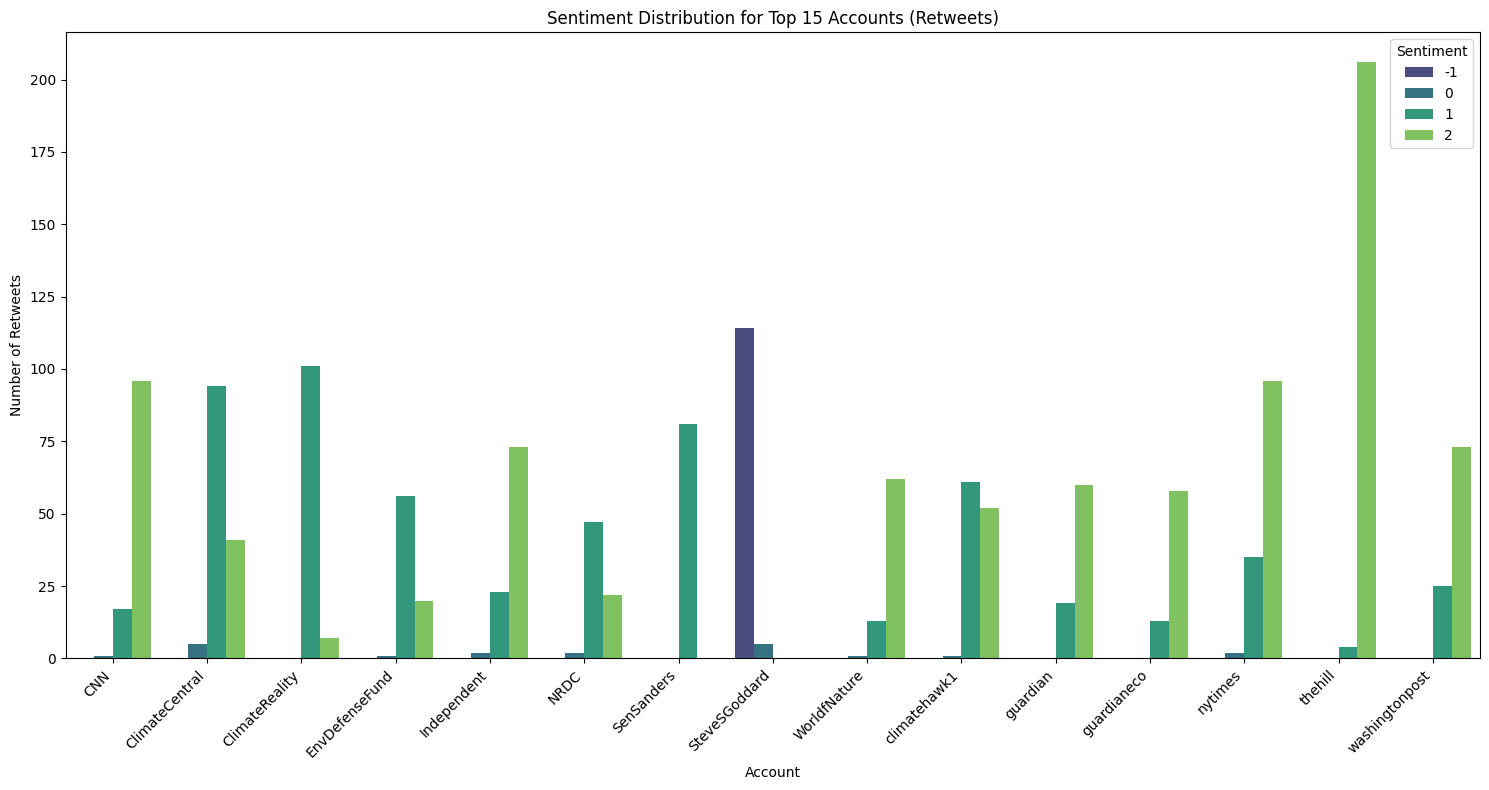

In [ ]:
plt.figure(figsize=(15, 8))
sns.barplot(data=top_accounts_sentiment_long, x='account', y='count', hue='sentiment', palette='viridis')
plt.title(f'Sentiment Distribution for Top {N} Accounts (Retweets)')
plt.xlabel('Account')
plt.ylabel('Number of Retweets')
plt.xticks(rotation=45, ha='right')
plt.legend(title='Sentiment')
plt.tight_layout()
plt.show()

## Rangkuman:

### Temuan Utama Analisis Data

* Sebanyak 21.922 pesan teridentifikasi sebagai retweet, berdasarkan awalan "RT @".
* Nama akun berhasil diekstraksi dari pesan retweet.
* Analisis sentimen retweet per akun menunjukkan distribusi yang bervariasi di berbagai akun.
* 15 akun teratas berdasarkan volume retweet menunjukkan profil sentimen yang beragam dalam retweet mereka, dengan beberapa akun memiliki proporsi retweet positif atau negatif yang lebih tinggi daripada yang lain.

### Wawasan atau Langkah Selanjutnya

* Selidiki akun dengan distribusi sentimen yang berbeda secara signifikan dalam retweet mereka untuk memahami potensi alasan di balik pola ini (misalnya, jenis konten yang mereka retweet, sentimen dari tweet asli).
* Analisis sentimen dari tweet asli dari akun-akun yang paling banyak diretweet ini untuk melihat apakah sentimen retweet mencerminkan sentimen sumbernya.

In [ ]:
account_name = 'CNN'
tweets_from_account = df_retweets[df_retweets['account'] == account_name]
print(f"Tweets from account: @{account_name}")
display(tweets_from_account)

Tweets from account: @CNN


,sentiment,message,tweetid,vader_sentiment_score,account
1151,2,"RT @CNN: Julia Louis-Dreyfus, who plays a president on 'Veep,' cut a video backing Clinton over her climate change positionÃ¢â‚¬Â¦",794088608399405056,-0.0000,CNN
3738,2,RT @CNN: Kids are taking the feds -- and possibly Trump -- to court over climate change https://t.co/oGw21W7Skw,797008381164867584,0.0000,CNN
6018,1,RT @CNN: No snow where there should be. Bleached anemones. Cracks in the ice. This is what climate change looks like:Ã¢â‚¬Â¦,798845888726601728,-0.2960,CNN
6990,2,RT @CNN: China slams Donald Trump's claim that climate change is a Chinese hoax https://t.co/19u33vgbQe https://t.co/rFZOJ3XACd,799889721967030272,-0.2732,CNN
7547,2,RT @CNN: President-elect Donald Trump acknowledges 'some connectivity' between climate change and human activity…,801166584127561728,0.0000,CNN
...,...,...,...,...,...
42850,1,RT @CNN: Whale sharks are under threat from climate change. Meet the fishermen trying to save the world$q$s biggest fish. https://t.co/x0NJEj…,765910201014689792,-0.0516,CNN
42925,2,RT @CNN: Bill Nye: Climate change is reason for Louisiana floods — and it$q$s going to happen again https://t.co/3q5KMjTJmo https://t.co/otPJ…,768127601797894145,0.0000,CNN
43365,0,RT @CNN: #CNNRealityCheck: Clinton said Trump called climate change a hoax “created by the Chinese.” TRUE. He tweeted that. https://t.co/B3…,780585150946115584,0.3470,CNN
43420,2,RT @CNN: Trump campaign manager: Trump $q$believes that global warming is naturally occurring$q$ https://t.co/yc47mjuFAB https://t.co/sUa6rXLTDk,780748450669395968,0.1531,CNN


In [ ]:
vader_sentiment_by_original_sentiment = df_cleaned.groupby('sentiment')['vader_sentiment_score'].agg(['mean', 'median', 'std', 'min', 'max']).reset_index()
print("VADER Sentiment Score Statistics by Original Sentiment Label:")
display(vader_sentiment_by_original_sentiment)

VADER Sentiment Score Statistics by Original Sentiment Label:


,sentiment,mean,median,std,min,max
0,-1,-0.084151,0.0,0.417905,-0.9595,0.9483
1,0,0.061752,0.0,0.371802,-0.9740,0.9327
2,1,-0.026087,0.0,0.416431,-0.9705,0.9528
3,2,-0.042891,0.0,0.316388,-0.9360,0.8885


In [ ]:
account_to_investigate = 'Independent'
tweets_from_investigated_account = df_retweets[df_retweets['account'] == account_to_investigate]
print(f"Tweets from account: @{account_to_investigate}")
display(tweets_from_investigated_account)

Tweets from account: @Independent


,sentiment,message,tweetid,vader_sentiment_score,account
589,2,RT @Independent: China slams Donald TrumpÃ¢â‚¬â„¢s plan to back out of climate change agreement https://t.co/Bo78HT1eQ3 https://t.co/k0XQvcpr4l,793495112529489921,0.4939,Independent
2826,1,RT @Independent: Donald Trump's views on climate change make him a danger to us all https://t.co/6F0cIH9OSY,796378459996037120,-0.5267,Independent
2968,1,RT @Independent: Donald Trump's views on climate change make him a danger to us all | @CarolineLucas https://t.co/6F0cIH9OSY https://t.co/fÃ¢â‚¬Â¦,796486248953167872,-0.5267,Independent
3118,1,RT @Independent: Donald Trump's views on climate change make him a danger to us all https://t.co/6F0cIGSduo,796593164173901824,-0.5267,Independent
4192,2,RT @Independent: Emergency campaign launched to convince Trump climate change is real. Failure risks 'planetary disaster' https://t.co/VwylÃ¢â‚¬Â¦,797371792579067904,-0.8625,Independent
...,...,...,...,...,...
38767,2,RT @Independent: US defence chiefs have issued a grave warning about climate change https://t.co/qLUqn0pBaR https://t.co/yFvJzzWefy,657141112495206400,-0.5574,Independent
40275,2,"RT @Independent: Climate change and flooding should be treated as a national security threat, Labour says https://t.co/rDBIaH1UiE",682233427316338688,-0.2500,Independent
41355,0,RT @Independent: The moment Hillary Clinton lost her temper with a climate change activist https://t.co/hrtVKiY9ik,716370289383309312,-0.6249,Independent
42464,0,RT @Independent: The new environment secretary who asked if climate change was real on her first day as energy minster https://t.co/gOuW0Oo…,754098849807949824,0.2732,Independent


## Cleaning Symbol

In [ ]:
import re

def clean_text_comprehensive(text):
    text = text.replace('Ã¢â‚¬â„¢', "'").replace('Ã¢â‚¬Å“', '"').replace('Ã¢â‚¬Å“', '"')
    text = text.replace('Ã¢â‚¬Â¦', '...')
    text = re.sub(r'[^\x00-\x7F]+', '', text)
    text = re.sub(r'^RT @\w+:', '', text)
    text = re.sub(r'http\S+|https\S+', '', text)
    text = text.replace('$q$', '')
    text = text.strip()
    return text

# Apply the comprehensive cleaning function
df_cleaned['message'] = df_cleaned['message'].apply(clean_text_comprehensive)
df_retweets['message'] = df_retweets['message'].apply(clean_text_comprehensive)

display(df_cleaned.head())

/tmp/ipython-input-689422335.py:19: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  df_cleaned['message'] = df_cleaned['message'].apply(clean_text_comprehensive)
/tmp/ipython-input-689422335.py:20: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  df_retweets['message'] = df_retweets['message'].apply(clean_text_comprehensive)


,sentiment,message,tweetid,vader_sentiment_score,detected_language
0,-1,@tiniebeany climate change is an interesting hustle as it was global warming but the planet stopped warming for 15 yes while the suv boom,792927353886371840,0.6428,en
1,1,"Watch #BeforeTheFlood right here, as @LeoDiCaprio travels the world to tackle climate change htt...",793124211518832641,0.0000,en
2,1,Fabulous! Leonardo #DiCaprio's film on #climate change is brilliant!!! Do watch. via @youtube,793124402388832256,0.8544,en
3,1,Just watched this amazing documentary by leonardodicaprio on climate change. We all think this...,793124635873275904,0.6705,en
4,2,"Pranita Biswasi, a Lutheran from Odisha, gives testimony on effects of climate change &amp; natural disasters on the po...",793125156185137153,-0.2732,en


## Compare Before and After Cleaning

In [ ]:
pd.set_option('display.max_colwidth', None)

import re

def remove_urls_and_rt(text):
    text = text.replace('Ã¢â‚¬â„¢', "'").replace('Ã¢â‚¬Å“', '"').replace('Ã¢â‚¬Å“', '"')
    text = text.replace('Ã¢â‚¬Â¦', '...')
    text = re.sub(r'[^\x00-\x7F]+', '', text)
    text = re.sub(r'^RT @\w+:', '', text)
    text = re.sub(r'http\S+|https\S+', '', text)
    text = text.replace('$q$', '')
    text = text.strip()
    return text

def contains_non_ascii(text):
    return any(ord(char) > 127 for char in text)

messages_with_strange_symbols = df[df['message'].apply(contains_non_ascii)]
sample_messages_before = messages_with_strange_symbols['message'].head(10).tolist()
sample_messages_after = [remove_urls_and_rt(msg) for msg in sample_messages_before]

comparison_df_samples = pd.DataFrame({'Before Cleaning': sample_messages_before, 'After Cleaning': sample_messages_after})
print("Contoh teks dengan simbol aneh (Sebelum dan Sesudah Pembersihan dengan fungsi terbaru):")
display(comparison_df_samples)

Contoh teks dengan simbol aneh (Sebelum dan Sesudah Pembersihan dengan fungsi terbaru):


,Before Cleaning,After Cleaning
0,"RT @NatGeoChannel: Watch #BeforeTheFlood right here, as @LeoDiCaprio travels the world to tackle climate change https://t.co/LkDehj3tNn httÃ¢â‚¬Â¦","Watch #BeforeTheFlood right here, as @LeoDiCaprio travels the world to tackle climate change htt..."
1,RT @Mick_Fanning: Just watched this amazing documentary by leonardodicaprio on climate change. We all think thisÃ¢â‚¬Â¦ https://t.co/kNSTE8K8im,Just watched this amazing documentary by leonardodicaprio on climate change. We all think this...
2,"RT @cnalive: Pranita Biswasi, a Lutheran from Odisha, gives testimony on effects of climate change &amp; natural disasters on the poÃ¢â‚¬Â¦","Pranita Biswasi, a Lutheran from Odisha, gives testimony on effects of climate change &amp; natural disasters on the po..."
3,"RT @cnalive: Pranita Biswasi, a Lutheran from Odisha, gives testimony on effects of climate change &amp; natural disasters on the poÃ¢â‚¬Â¦","Pranita Biswasi, a Lutheran from Odisha, gives testimony on effects of climate change &amp; natural disasters on the po..."
4,"RT @CCIRiviera: Presidential Candidate #DonaldTrump is Ã¢â‚¬Å“dangerousÃ¢â‚¬ï† on climate change, says #monaco Ã¢â‚¬â„¢s Prince AlbertÃ¢â‚¬Â¦","Presidential Candidate #DonaldTrump is ""dangerous on climate change, says #monaco 's Prince Albert..."
5,RT @AmericanIndian8: Leonardo DiCaprio's climate change documentary is free for a week https://t.co/ITpdZ6kCeg\n#INDIGENOUS #TAIRP https://tÃ¢â‚¬Â¦,Leonardo DiCaprio's climate change documentary is free for a week \n#INDIGENOUS #TAIRP
6,RT @DrDeJarnett: It's vital that the public health community addresses climate change- via @Climate4Health's Tabola #APHA2016 https://t.co/Ã¢â‚¬Â¦,It's vital that the public health community addresses climate change- via @Climate4Health's Tabola #APHA2016
7,"Bangladesh did not cause climate change, so the country does not need Ã¢â‚¬Å“aidÃ¢â‚¬ï†; instead it needs compensation for theÃ¢â‚¬Â¦ https://t.co/ecGXgRNROP","Bangladesh did not cause climate change, so the country does not need ""aid; instead it needs compensation for the..."
8,"RT @NatGeoChannel: Watch #BeforeTheFlood right here, as @LeoDiCaprio travels the world to tackle climate change https://t.co/LkDehj3tNn httÃ¢â‚¬Â¦","Watch #BeforeTheFlood right here, as @LeoDiCaprio travels the world to tackle climate change htt..."
9,"RT @WorldResources: Reflections on Leonardo DiCaprioÃ¢â‚¬â„¢s new #climate change film, #BeforeTheFlood https://t.co/YRrLgtZRbc https://t.co/A0tWUÃ¢â‚¬Â¦","Reflections on Leonardo DiCaprio's new #climate change film, #BeforeTheFlood"


In [ ]:
%pip install langdetect

## Detect language Except English


In [ ]:
from langdetect import detect
from langdetect import LangDetectException

def detect_language(text):
    try:
        return detect(text)
    except LangDetectException:
        return 'unknown'

df_cleaned['detected_language'] = df_cleaned['message'].apply(detect_language)

display(df_cleaned.head())

/tmp/ipython-input-518860559.py:10: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  df_cleaned['detected_language'] = df_cleaned['message'].apply(detect_language)


,sentiment,message,tweetid,vader_sentiment_score,detected_language
0,-1,@tiniebeany climate change is an interesting hustle as it was global warming but the planet stopped warming for 15 yes while the suv boom,792927353886371840,0.6428,en
1,1,"Watch #BeforeTheFlood right here, as @LeoDiCaprio travels the world to tackle climate change htt...",793124211518832641,0.0000,en
2,1,Fabulous! Leonardo #DiCaprio's film on #climate change is brilliant!!! Do watch. via @youtube,793124402388832256,0.8544,en
3,1,Just watched this amazing documentary by leonardodicaprio on climate change. We all think this...,793124635873275904,0.6705,en
4,2,"Pranita Biswasi, a Lutheran from Odisha, gives testimony on effects of climate change &amp; natural disasters on the po...",793125156185137153,-0.2732,en


## Filter and display non-english tweets



In [ ]:
non_english_tweets = df_cleaned[df_cleaned['detected_language'] != 'en']
print("Non-English Tweets:")
display(non_english_tweets.head())
print(f"\nNumber of non-English tweets found: {non_english_tweets.shape[0]}")

Non-English Tweets:


,sentiment,message,tweetid,vader_sentiment_score,detected_language
5,0,Unamshow awache kujinga na iko global warming,793125429418815489,0.1531,sw
318,0,"Numinipis na ang yelo sa Arctic Circle, pati si Santa nangangayayat na. Nakakatakot talaga ang global warming",793323071796940800,0.1531,tl
356,0,jiyong: girls are so hot\njiyong: guys are hot too oh damn\njiyong: why is everyone so hot\ndaesung: global warming.,793357444738981888,-0.2732,tl
597,1,let's talk climate change,793497173983764481,0.0000,fr
796,0,#AlGore &amp; climate change,793646936456777728,0.0000,it



Number of non-English tweets found: 669


## Rangkuman:

### Temuan Utama Analisis Data

* Pustaka `langdetect` berhasil diinstal untuk melakukan deteksi bahasa.
* Kolom baru bernama `detected_language` ditambahkan ke DataFrame `df_cleaned`, yang berisi identifikasi bahasa untuk setiap tweet.
* 627 tweet dalam dataset teridentifikasi menggunakan bahasa selain bahasa Inggris.


In [ ]:
non_english_tweets.sample(10)

,sentiment,message,tweetid,vader_sentiment_score,detected_language
40029,1,@GOP,676871424368226304,0.0000,de
33131,0,@Snowhayt Hahaha malay mo climate change,953632177631178753,0.5574,tl
37080,0,,607605322287476736,0.0000,unknown
20894,0,Isa siyang malaking kontribusyon sa global warming..,861790653092470784,0.0000,tl
3791,0,global warming,797042110562058240,0.1531,so
29377,-1,Blame climate change,943451214003556353,-0.3400,it
40623,0,"skrg sesi nya bapak Nyoman Iswara Yoga Dir Media &amp; Komunikasi WWF Indonesia, tentang Climate Change, #KumbangEH2016",693321771345321984,0.0000,id
8896,0,I was like do you believe in global warming,807633809931845632,0.4767,af
43332,0,OH?\n\n#DebateNight,780577905294254080,0.0000,nl
41707,0,CHANGE CLIMATE CHANGE!,727031002623696896,0.0000,vi


In [ ]:
language_distribution = non_english_tweets['detected_language'].value_counts()
print("Distribusi non inggris:")
display(language_distribution)

Distribusi non inggris:


,count
detected_language,
it,89
tl,87
id,76
nl,76
af,65
fr,61
de,51
so,32
ro,18


## Show Netherland Tweets

In [ ]:
nl_tweets = non_english_tweets[non_english_tweets['detected_language'] == 'nl']
print("Tweets in Dutch (nl):")
display(nl_tweets.head())
print(f"\nNumber of tweets in Dutch found: {nl_tweets.shape[0]}")

Tweets in Dutch (nl):


,sentiment,message,tweetid,vader_sentiment_score,detected_language
2643,0,He doesn't believe in climate change guys,796233923902787584,0.0000,nl
3601,1,"What climate change deniers, like Donald Trump, believe - BBC News",796883407296929792,0.1027,nl
3766,1,Civic engagement vodeo on climate change @RichardMunang @HElHaiteCop22 @UNEP #COP22 @NiliMajumder @...,797024544791941120,0.4588,nl
4553,1,"What climate change deniers, like Donald Trump, believe",797773359861923840,0.1027,nl
7052,1,"@HendyGardenLove ...and all climate change deniers, no doubt! HELP!!!!",799999991196499968,-0.7887,nl



Number of tweets in Dutch found: 76


## Show Italia Tweets

In [ ]:
tl_tweets = non_english_tweets[non_english_tweets['detected_language'] == 'it']
print("Tweets in Italia(it):")
display(tl_tweets.head())
print(f"\nNumber of tweets in found: {tl_tweets.shape[0]}")

Tweets in Italia(it):


,sentiment,message,tweetid,vader_sentiment_score,detected_language
796,0,#AlGore &amp; climate change,793646936456777728,0.0000,it
1030,0,"Cop22, da Parigi a Marrakesh: la sfida contro il global warming",793923859783254016,0.1531,it
1377,0,@i_artaza @COP22 @UNFCCC @ConversationUS regarding climate change.,794456203510300672,0.0000,it
1389,0,#AccordodiParigi Stop sussidi a fonti fossili contro climate change. @LeonaroDicaprio,794471994792312832,-0.2960,it
1574,0,HAARP 2015 Reveals climate change via @UnzipW,794833070620835840,0.0000,it



Number of tweets in found: 89


## Show Tagalog Tweets

In [ ]:
tl_tweets = non_english_tweets[non_english_tweets['detected_language'] == 'tl']
print("Tweets in Tagalog (tl):")
display(tl_tweets.head())
print(f"\nNumber of tweets in Tagalog found: {tl_tweets.shape[0]}")

Tweets in Tagalog (tl):


,sentiment,message,tweetid,vader_sentiment_score,detected_language
318,0,"Numinipis na ang yelo sa Arctic Circle, pati si Santa nangangayayat na. Nakakatakot talaga ang global warming",793323071796940800,0.1531,tl
356,0,jiyong: girls are so hot\njiyong: guys are hot too oh damn\njiyong: why is everyone so hot\ndaesung: global warming.,793357444738981888,-0.2732,tl
3425,0,I blame global warming.,796797393748590592,-0.2023,tl
3817,0,Yung seminar kanina na parang kinokonsensya ka pa kung bat ka pa nabuhay dahil nakakacontribute ka lang sa climate change tf,797055919687278592,0.0000,tl
7282,0,@pulbora dahil ba sa climate change? nagtatampo ako sayo di mo pinapansin yung tinag ko sayo sa fb!!!,800384981914632193,0.0000,tl



Number of tweets in Tagalog found: 87


## Drop non-english tweets



In [ ]:
df_english = df_cleaned[df_cleaned['detected_language'] == 'en']
df_english.shape

(40364, 5)

## Drop Label News

In [ ]:
df_english = df_english[df_english['sentiment'] != 2]
df_english.shape

(31348, 5)

In [ ]:
df_english

,sentiment,message,tweetid,vader_sentiment_score,detected_language
0,-1,@tiniebeany climate change is an interesting hustle as it was global warming but the planet stopped warming for 15 yes while the suv boom,792927353886371840,0.6428,en
1,1,"Watch #BeforeTheFlood right here, as @LeoDiCaprio travels the world to tackle climate change htt...",793124211518832641,0.0000,en
2,1,Fabulous! Leonardo #DiCaprio's film on #climate change is brilliant!!! Do watch. via @youtube,793124402388832256,0.8544,en
3,1,Just watched this amazing documentary by leonardodicaprio on climate change. We all think this...,793124635873275904,0.6705,en
8,0,Leonardo DiCaprio's climate change documentary is free for a week \n#INDIGENOUS #TAIRP,793127097854197761,0.5106,en
...,...,...,...,...,...
43936,1,#AikBaatSuniThi \nGlobal warming has negative effect on the melting down of glaciers,791293803877502976,-0.4767,en
43938,1,"Dear @realDonaldTrump,\nYeah right. Human Mediated Climate Change is a Chinese urban legend.",791307031919550464,0.5859,en
43939,1,What will your respective parties do to prevent climate change globally? #ZPNDebate,791316857403936768,0.6808,en
43941,0,"i still cant believe this gif of taehyung saved the human race, stopped global warming and watered every plant on",791390042136641537,0.3612,en


## Load Only message and sentiment column

In [ ]:
df_subset = df_english[['message', 'sentiment']].copy()
df_subset

,message,sentiment
0,@tiniebeany climate change is an interesting hustle as it was global warming but the planet stopped warming for 15 yes while the suv boom,-1
1,"Watch #BeforeTheFlood right here, as @LeoDiCaprio travels the world to tackle climate change htt...",1
2,Fabulous! Leonardo #DiCaprio's film on #climate change is brilliant!!! Do watch. via @youtube,1
3,Just watched this amazing documentary by leonardodicaprio on climate change. We all think this...,1
8,Leonardo DiCaprio's climate change documentary is free for a week \n#INDIGENOUS #TAIRP,0
...,...,...
43936,#AikBaatSuniThi \nGlobal warming has negative effect on the melting down of glaciers,1
43938,"Dear @realDonaldTrump,\nYeah right. Human Mediated Climate Change is a Chinese urban legend.",1
43939,What will your respective parties do to prevent climate change globally? #ZPNDebate,1
43941,"i still cant believe this gif of taehyung saved the human race, stopped global warming and watered every plant on",0


In [ ]:
cleaned_filename = "cleaned_tweets.csv"
df_subset.to_csv(cleaned_filename, index=False)
print(f"Cleaned dataset saved to {cleaned_filename}")

Cleaned dataset saved to cleaned_tweets.csv
